<center>
<h1>[Python で 超実習ディープラーニング](https://www.seminar-info.jp/entry/seminars/view/1/4174)</h1>
<h3><strong>実践！ 強化学習・画像認識・自然言語処理・ロボティクス</strong></h3>
</center>

<center>
![](https://www.seminar-info.jp/entry/img/logo_ov.jpg)
</center>

<div align='right'>
<a href='mailto:asakawa@ieee.org'>Shin Aasakawa</a>, all rights reserved.<br>
Date: 15/Mar/2019<br>
 MIT license
</div>

----

# 信長の夢はどのような下天の夢だったのだろうか？ 
## keras による Deep Dreaming 

[Original](https://github.com/keras-team/keras/blob/master/examples/deep_dream.py)

- ここでは deep dream によって信長の夢を見てみましょう
- 以下のセルをシフトキーを押しながらエンターキーを押すことで，逐次見ていきましょう

In [2]:
# shift+enter で先に進んでください
'''
#Deep Dreaming in Keras.

Run the script with:
```python
python deep_dream.py path_to_your_base_image.jpg prefix_for_results
```
e.g.:
```python
python deep_dream.py img/mypic.jpg results/dream
```
'''
from __future__ import print_function

from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
import scipy
import argparse

from keras.applications import inception_v3
from keras import backend as K

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

K.set_learning_phase(0)



Model loaded.


In [3]:
# インセプションモジュールを読み込みます
# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')


Model loaded.


In [4]:
# 続いて夢を見る準備作業です。shift+enter で次に進んでください
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    if layer_name not in layer_dict:
        raise ValueError('Layer ' + layer_name + ' not found in model.')
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values


def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x


"""Process:

- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.

To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""


'Process:\n\n- Load the original image.\n- Define a number of processing scales (i.e. image shapes),\n    from smallest to largest.\n- Resize the original image to the smallest scale.\n- For every scale, starting with the smallest (i.e. current one):\n    - Run gradient ascent\n    - Upscale image to the next scale\n    - Reinject the detail that was lost at upscaling time\n- Stop when we are back to the original size.\n\nTo obtain the detail lost during upscaling, we simply\ntake the original image, shrink it down, upscale it,\nand compare the result to the (resized) original image.\n'

In [0]:
# ハイパーパラメータの設定です。慣れてきたら変更してみてください。
# shift+enter で先に進んで下さい
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.


In [7]:
# 夢うつつではない現実の信長を入手します。shift+enter で先に進んでください
!wget https://rekijin.com/wp-content/uploads/2016/05/e8fe5cd3bbefc390a3ac9a1296a8e42b-2.jpg

--2019-03-12 01:12:45--  https://rekijin.com/wp-content/uploads/2016/05/e8fe5cd3bbefc390a3ac9a1296a8e42b-2.jpg
Resolving rekijin.com (rekijin.com)... 104.20.219.77, 104.20.218.77
Connecting to rekijin.com (rekijin.com)|104.20.219.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120680 (118K) [image/jpeg]
Saving to: ‘e8fe5cd3bbefc390a3ac9a1296a8e42b-2.jpg.1’

e8fe5cd3bbefc390a3a 100%[===================>] 117.85K  --.-KB/s    in 0.02s   

2019-03-12 01:12:45 (7.60 MB/s) - ‘e8fe5cd3bbefc390a3ac9a1296a8e42b-2.jpg.1’ saved [120680/120680]



In [8]:
# わかりにくいので名前を変更します。shift+enter で先に進んでください
!mv 'e8fe5cd3bbefc390a3ac9a1296a8e42b-2.jpg' nobunaga.jpg
!ls nobunaga.jpg

nobunaga.jpg


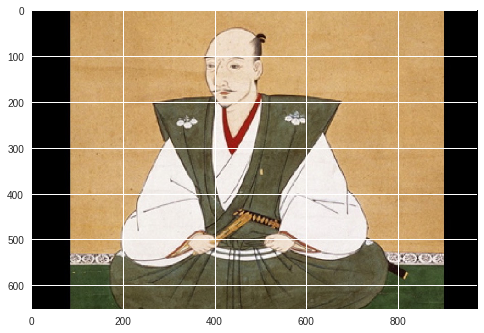

In [10]:
# 信長を確認します。shift+enter を押してください
import matplotlib.pyplot as plt
from PIL import Image
gimg = Image.open('nobunaga.jpg')
plt.imshow(gimg)

In [0]:
# 画像の前処理を施します。shift+enter で次に進んでください
base_image_path='nobunaga.jpg'
img = preprocess_image(base_image_path)
result_prefix = 'nobonagas-dream'

In [12]:
# ここからが夢の処理です。信長はどんな夢を見たのでしょうか。shift+enter で確認します。
# 少し時間がかかります。結果が出るまでお待ち下さい。
img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img(result_prefix + '.png', deprocess_image(np.copy(img)))


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing image shape (332, 496)
..Loss value at 0 : 0.78051865
..Loss value at 1 : 1.0166063
..Loss value at 2 : 1.3035424
..Loss value at 3 : 1.5841575
..Loss value at 4 : 1.8711803
..Loss value at 5 : 2.1631832
..Loss value at 6 : 2.4745586
..Loss value at 7 : 2.78079
..Loss value at 8 : 3.07916
..Loss value at 9 : 3.3902342
..Loss value at 10 : 3.6804457
..Loss value at 11 : 3.9727652
..Loss value at 12 : 4.2708807
..Loss value at 13 : 4.5692253
..Loss value at 14 : 4.861044
..Loss value at 15 : 5.164905
..Loss value at 16 : 5.438044
..Loss value at 17 : 5.748228
..Loss value at 18 : 6.0320816
..Loss value at 19 : 6.3210735
Processing image shape (465, 695)
..Loss value at 0 : 1.5129066
..Loss value at 1 : 2.303975
..Loss value at 2 : 2.9694061
..Loss value at 3 : 3.522593
..Loss value at 4 : 4.031311
..Loss value at 5 : 4.5170927
..Loss value at 6 : 4.9653573
..Loss value at 7 : 5.418128
..Loss value at 8 : 5.83558
..Loss value at 9 : 6.216151
..Loss value at 10 : 6.61934
..Loss 

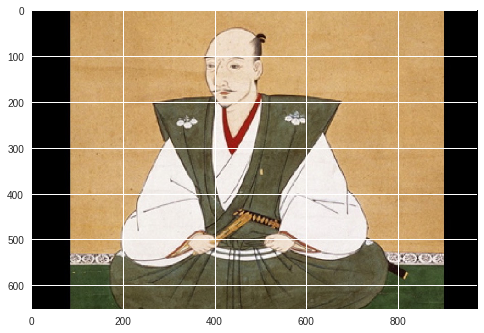

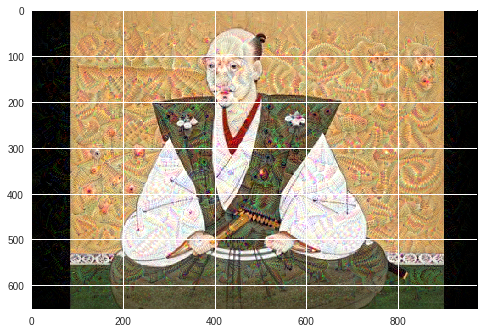

In [13]:
# それでは夢の表示です。shift+enter してください
gimg = Image.open('nobunaga.jpg')
dream_img = Image.open(result_prefix + '.png')
plt.imshow(gimg)
plt.show()
plt.imshow(dream_img)

<div align='center'><font color='green' size='+3'>以上です</br>
  おあとがよろしいようで</font>
  </div>